# Вебинар 6. Сегментация   

* Домашнее задание:  
1.	Попробуйте запустить с методички. ИЛИ
2.	Доделать код начатый на уроке. Можно пользоваться готовыми натренированными нейронками.

Сдавать как обычно.

## Вставляем часть кода из методички по лабораторной работе №4
лабораторная работа № 4 - [ссылка GeekBrains](https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fgbcdn.mrgcdn.ru%2Fuploads%2Fasset%2F5874610%2Fattachment%2F92eb4ba1ca47bd7eefb6f549d5992e7e.docx&wdOrigin=BROWSELINK)  

и загружаем данные для train и test:  
train - [ссылка GeekBrains](https://gbcdn.mrgcdn.ru/uploads/asset/5874612/attachment/8adee08ef31aa26afce66d0dd8d3f126.zip)  
test - [ссылка GeekBrains](https://gbcdn.mrgcdn.ru/uploads/asset/5874611/attachment/49824faeeeaa47bc07fa55b81334a613.zip)

In [1]:
# #Устанавливаем пакеты в окружение, если они не установлены

# #библиотека для работы с изображениями в языке программирования Python
# !pip install pillow 

# #библиотека языка Python, добавляющая поддержку больших многомерных массивов и матриц
# !pip install numpy

# #Python­-пакет с открытым кодом, который работает с массивами NumPy
# !pip install scikit-image

# #устанавливаем tensorflow для CPU
# !pip install tensorflow

# #устанавливаем keras
# !pip install scikeras[tensorflow]

# #отрисовка схем, графиков
# !pip install graphviz
# !pip install pydot

# !pip install matpLotLib

In [2]:
from PIL import Image   # библиотека для работы с изображениями в языке программирования Python
import os
import numpy as np      # библиотека языка Python, добавляющая поддержку больших многомерных массивов и матриц
from skimage import io  # Python­-пакет с открытым кодом, который работает с массивами NumPy
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, Dropout
from keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
# задаём константы
IMG_WIDTH = 640                       # Ширина итогового изображения
IMG_LENGTH = 768                      # Длина итогового изображения
IMG_SHAPE  = (IMG_WIDTH, IMG_LENGTH)  # Формат изображения (ширина, длина)
CLASSES = 6                           # Число классов сегментирования

In [4]:
def download_data(path):
    """
    Функция загрузки изображений.

    :param path: папка с изображениями; 
    :return: массив данных.
    """
    data = []
    for path_image in sorted(os.listdir(path=path)):
        image = Image.open(path + path_image)     # Открываем изображение.
        image = tf.image.resize(image, IMG_SHAPE) # Изменяем размер изображения до IMG_SHAPE
        data.append(np.array(image))              # Загружаем пиксели.
    return data

In [5]:
# Загружаем данные в массив
X_train = download_data("train/images/") # Исходные изображения из обучающей выборки данных
Y_train = download_data("train/masks/")  # Сегментированные исходные изображения из обучающей выборки
X_test = download_data("test/images/")   # Исходные изображения из тестовой выборки данных
Y_test = download_data("test/masks/")    # Сегментированные исходные изображения из тестовой выборки

### Объявление функций предобработки и пост обработки данных

In [6]:
# Атрибут palette используется для установки цвета полос. Это помогает различать данные
palette = {0 : (60, 16, 152),   # Building
           1 : (132, 41, 246),  # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58),  # Vegetation
           4 : (226, 169, 41),  # Water
           5 : (155, 155, 155)} # Unlabeled

# Переменная invert_palette позволяет проводить обратное преобразование, цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [7]:
# Данная функция преобразует результат сегментации нейронной сети в RGB изображение, удобное для восприятия пользователя
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)               # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2)    # ищем расстояние для каждого пикселя до 
                                                                                       # проверяемого класса по евклиду рас-ие
      condition = min_distance > distance             # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition]   # замена дистанции найденных элементов
      arr_2d[condition] = i                           # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

### Предобработка исходных изображений и сегментированных изображений в ответ сети

In [8]:
# Следующий блок кода подготавливает данные для использования нейронной сетью
X_train_pred = np.array(X_train).reshape([7, IMG_WIDTH, IMG_LENGTH, 3])/255 
X_test_pred = np.array(X_test).reshape([2, IMG_WIDTH, IMG_LENGTH, 3])/255   
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


In [9]:
X_train_pred.shape

(7, 640, 768, 3)

## Объявление топологии нейронной сети, компиляция и обучение
Взял готовую топологию - [Ссылка GitHub](https://github.com/Mazepov/Cat_Segmentation)

In [10]:
def unet_model(image_size, output_classes):

    #Входной слой
    input_layer = Input(shape=image_size + (3,))
    conv_1 = Conv2D(64, 4, activation=LeakyReLU(),
                                    strides=2, padding='same', kernel_initializer='glorot_normal',
                                    use_bias=False)(input_layer)
    #Сворачиваем
    conv_1_1 = Conv2D(128, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = BatchNormalization()(conv_1_1)

    #2
    conv_2 = Conv2D(256, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv_2)

    #3
    conv_3 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv_3)

    #4
    conv_4 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_3)
    batch_norm_4 = BatchNormalization()(conv_4)

    #5
    conv_5 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    #6
    conv_6 = Conv2D(512, 4, activation=LeakyReLU(), strides=2,
                                      padding='same', kernel_initializer='glorot_normal',
                                      use_bias=False)(batch_norm_5)


    #Разворачиваем
    #1
    up_1 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = Dropout(0.25)(batch_up_1)

    #2
    up_2 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = BatchNormalization()(up_2)
    batch_up_2 = Dropout(0.25)(batch_up_2)




    #3
    up_3 = Concatenate()([Conv2DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = BatchNormalization()(up_3)
    batch_up_3 = Dropout(0.25)(batch_up_3)




    #4
    up_4 = Concatenate()([Conv2DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = BatchNormalization()(up_4)


    #5
    up_5 = Concatenate()([Conv2DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = BatchNormalization()(up_5)


    #6
    up_6 = Concatenate()([Conv2DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = BatchNormalization()(up_6)


    #Выходной слой
    output_layer = Conv2DTranspose(output_classes, 4, activation='sigmoid', strides=2,
                                                   padding='same',
                                                   kernel_initializer='glorot_normal')(batch_up_6)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [11]:
model = unet_model(image_size=IMG_SHAPE, output_classes=CLASSES)

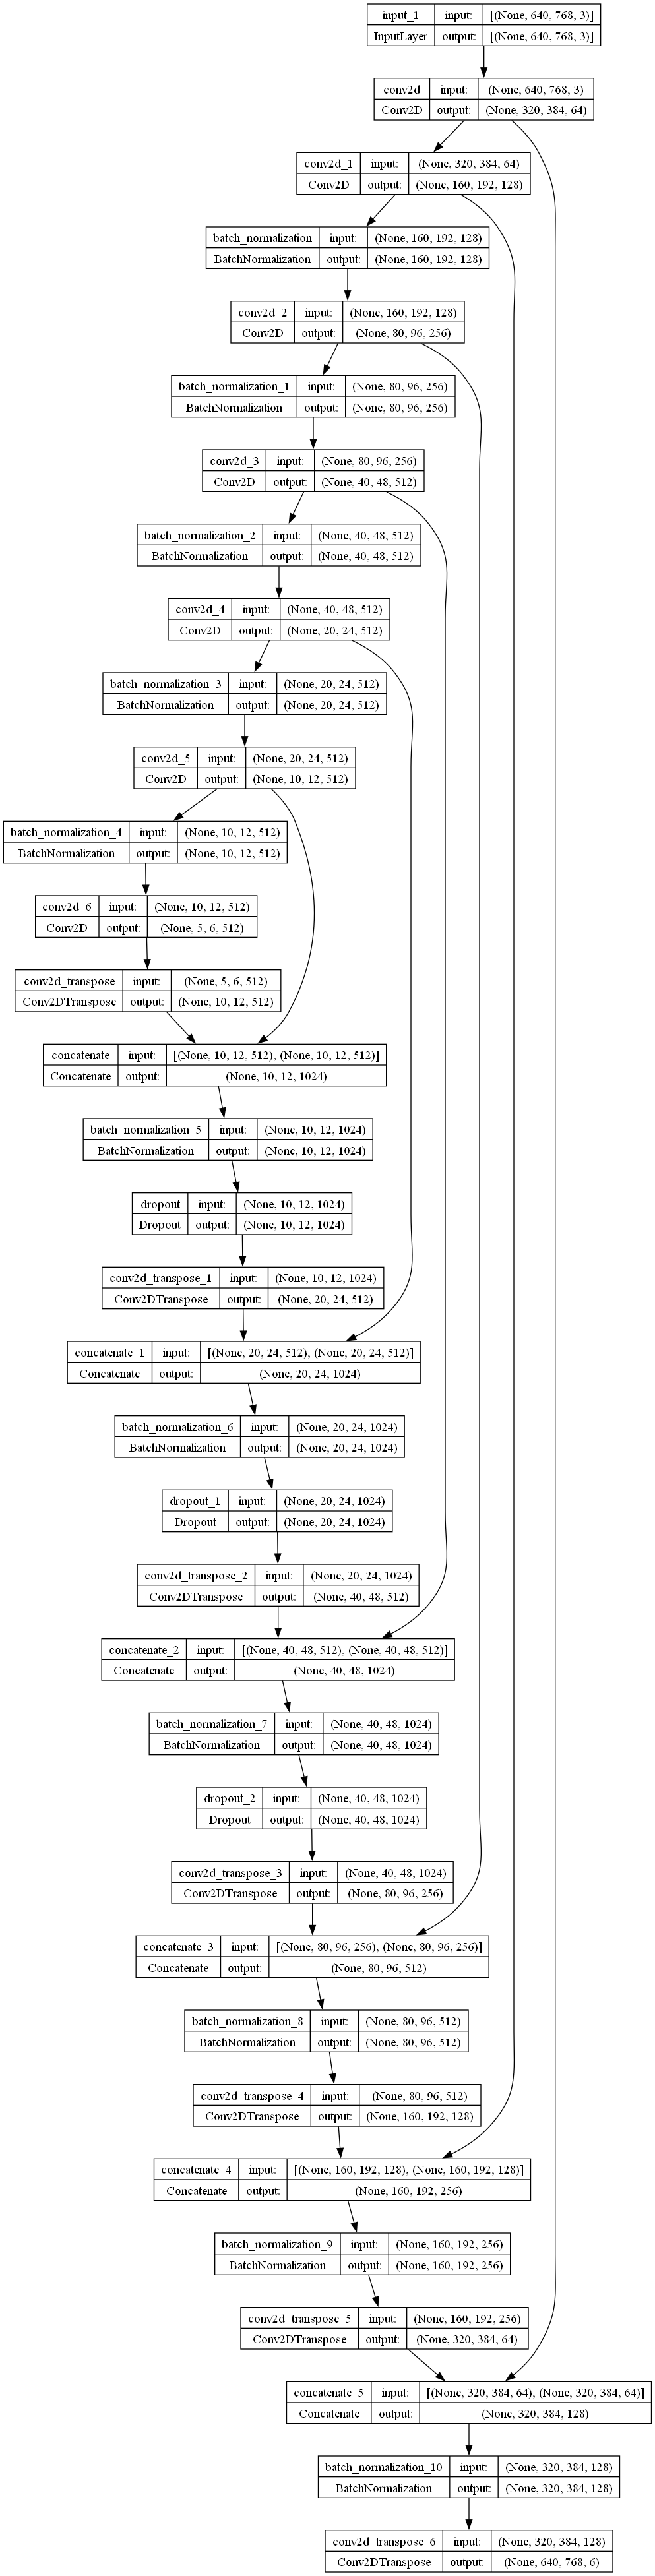

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
#Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 320, 384, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 192, 12  131072      ['conv2d[0][0]']                 
                                8)                                                            

In [14]:
# Обучаем модель
history = model.fit(X_train_pred, Y_train_pred, batch_size=1, epochs=100, validation_data=(X_test_pred, Y_test_pred))

Epoch 1/100
7/7 [==============================] - 10s 1s/step - loss: 1.5080 - accuracy: 0.4849 - val_loss: 7.5352 - val_accuracy: 0.2572
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 1.2540 - accuracy: 0.6451 - val_loss: 213.2045 - val_accuracy: 0.2556
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 1.0924 - accuracy: 0.6986 - val_loss: 1254.3807 - val_accuracy: 0.2551
Epoch 4/100
7/7 [==============================] - 7s 1s/step - loss: 1.0397 - accuracy: 0.6578 - val_loss: 1243.5553 - val_accuracy: 0.2420
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.9549 - accuracy: 0.7067 - val_loss: 1293.3799 - val_accuracy: 0.2388
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.9134 - accuracy: 0.7152 - val_loss: 1142.1250 - val_accuracy: 0.1675
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 0.9370 - accuracy: 0.7222 - val_loss: 1990.1150 - val_accuracy: 0.0228
Epoch 8/100
7/7 

### Отрисовка точности модели (при обучении и на тестовых данных)

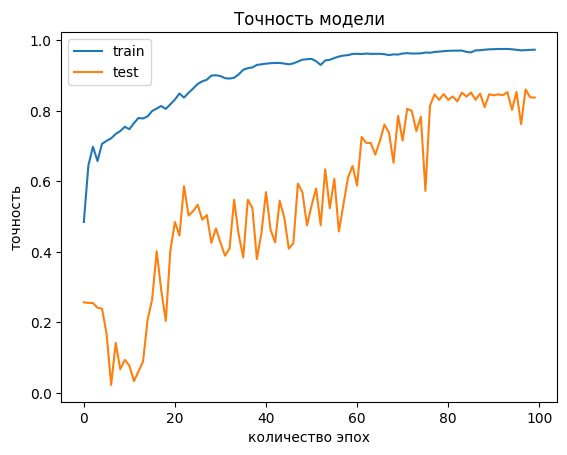

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Выполняем predict для двух тестовых картинок

In [16]:
# Делаем сегментацию для двух тестовых картинок
out = model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 1s 267ms/step


## Результат сегментации
Отрисовка картинок - [Руководство по subplots в matplotlib](https://teletype.in/@pythontalk/matplotlib_subplot_tutorial)

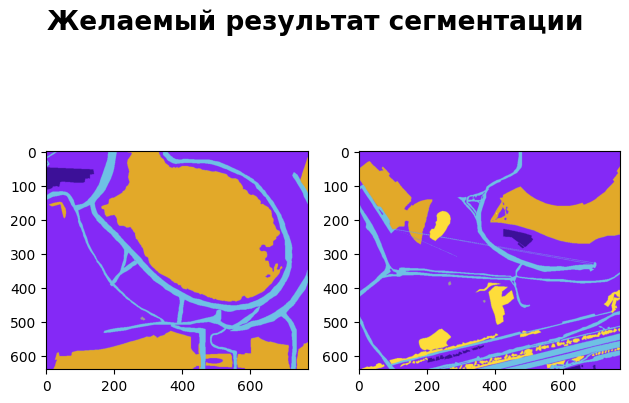

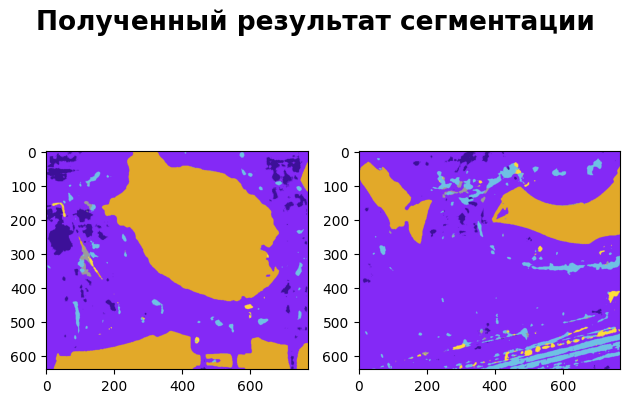

In [17]:
# Выведем 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

## Вывод:
### Точность полученной модели более 80% при 100 эпохах, полученный результат сегментации очень похож на желаемый результат, но не идеален.